<a href="https://colab.research.google.com/github/groda/big_data/blob/master/Spark_Standalone_Architecture_on_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90" alt="Logo Big Data for Beginners"></div></a>
# Getting to know the Spark Standalone Architecture
## on Google Colab  

This notebook has been created for Google Colab with the goal of getting to know Apache Spark™ and exploring the Spark standalone architecture.

After a quick introduction to Apache Spark™ we are going to start a single-node Spark on the Google Colab infrastructure, explore Spark's components and services and get to know the main configuration parameters.




## What is Spark

Apache Spark™  is a “*is a multi-language engine for executing data engineering, data science, and machine learning on single-node machines or clusters*” (https://spark.apache.org/).

Spark allows to run parallel/distributed algorithms by taking care of distributing tasks among the available computing resources. Based on the MapReduce programming paradigm, Spark improves on it by operating in memory, thus reducing disk I/O latency in multi-step data processing jobs.

Spark is developed in Scala and this is the language of choice for developing applications but also other programming languages are supported by Spark clients:

*   Python ([pyspark](https://spark.apache.org/docs/latest/api/python/))
*   R ([SparkR](https://spark.apache.org/docs/latest/sparkr.html) or [Sparklyr](https://spark.rstudio.com/))
*   Java ([Java API](https://spark.apache.org/docs/latest/api/java/) or [Spark Java](https://sparkjava.com/))
*   Julia ([Spark.jl](https://github.com/dfdx/Spark.jl))




### Prerequisites

Spark runs on both Windows and UNIX-like systems (e.g. Linux, Mac OS).

It requires a Java runtime version 8, 11, or 17. `java` should be in your system `PATH`, or the `JAVA_HOME` environment variable pointing to a Java installation.



#### Check that the required Java version is available:

On Google Colab the required Java is already installed.

In the next cell we are going to install Java in case it is not already available so that the notebook can be tested on a generic Ubuntu machine.

In [1]:
import os
import shutil
import subprocess


# set variable JAVA_HOME (install Java if necessary)
def is_java_installed():
  java = shutil.which("java")
  if java:
    os.environ['JAVA_HOME'] = os.path.realpath(java).split('/bin')[0]
    return True
  else:
    return False

def install_java():
    # Uncomment and modify the desired version
    # java_version= 'openjdk-11-jre-headless'
    # java_version= 'default-jre'
    # java_version= 'openjdk-17-jre-headless'
    # java_version= 'openjdk-18-jre-headless'
    java_version= 'openjdk-19-jre-headless'
    print(f"Java not found. Installing {java_version} ... (this might take a while)")
    try:
        cmd = f"apt install -y {java_version}"
        subprocess_output = subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        stdout_result = subprocess_output.stdout
        # Process the results as needed
        print("Done installing Java {}".format(java_version))
        os.environ['JAVA_HOME'] = os.path.realpath(shutil.which("java")).split('/bin')[0]
        print("JAVA_HOME is {}".format(os.environ['JAVA_HOME']))
    except subprocess.CalledProcessError as e:
        # Handle the error if the command returns a non-zero exit code
        lprint("Command failed with return code {}".format(e.returncode))
        print("stdout: {}".format(e.stdout))


# Install Java if not available
if is_java_installed():
    print("Java is already installed: {}".format(os.environ['JAVA_HOME']))
else:
    print("Installing Java")
    install_java()



Java is already installed: /usr/lib/jvm/temurin-11-jdk-amd64


### Download Spark

Spark can be downloaded from https://spark.apache.org/downloads.html.

There are a few pre-built versions that contain Hadoop distributions, a pre-built version without Hadoop, and the sources to build it yourself.

#### Why we're going to download the pre-built for Apache Hadoop

If you already have Hadoop, you will want to download the pre-built version without Hadoop.

For the sake of this demo, even though we are not planning to use Hadoop, we are going to download a pre-built version that includes Apache Hadoop because this contains some libraries needed by Spark that would otherwise need to be manually installed.

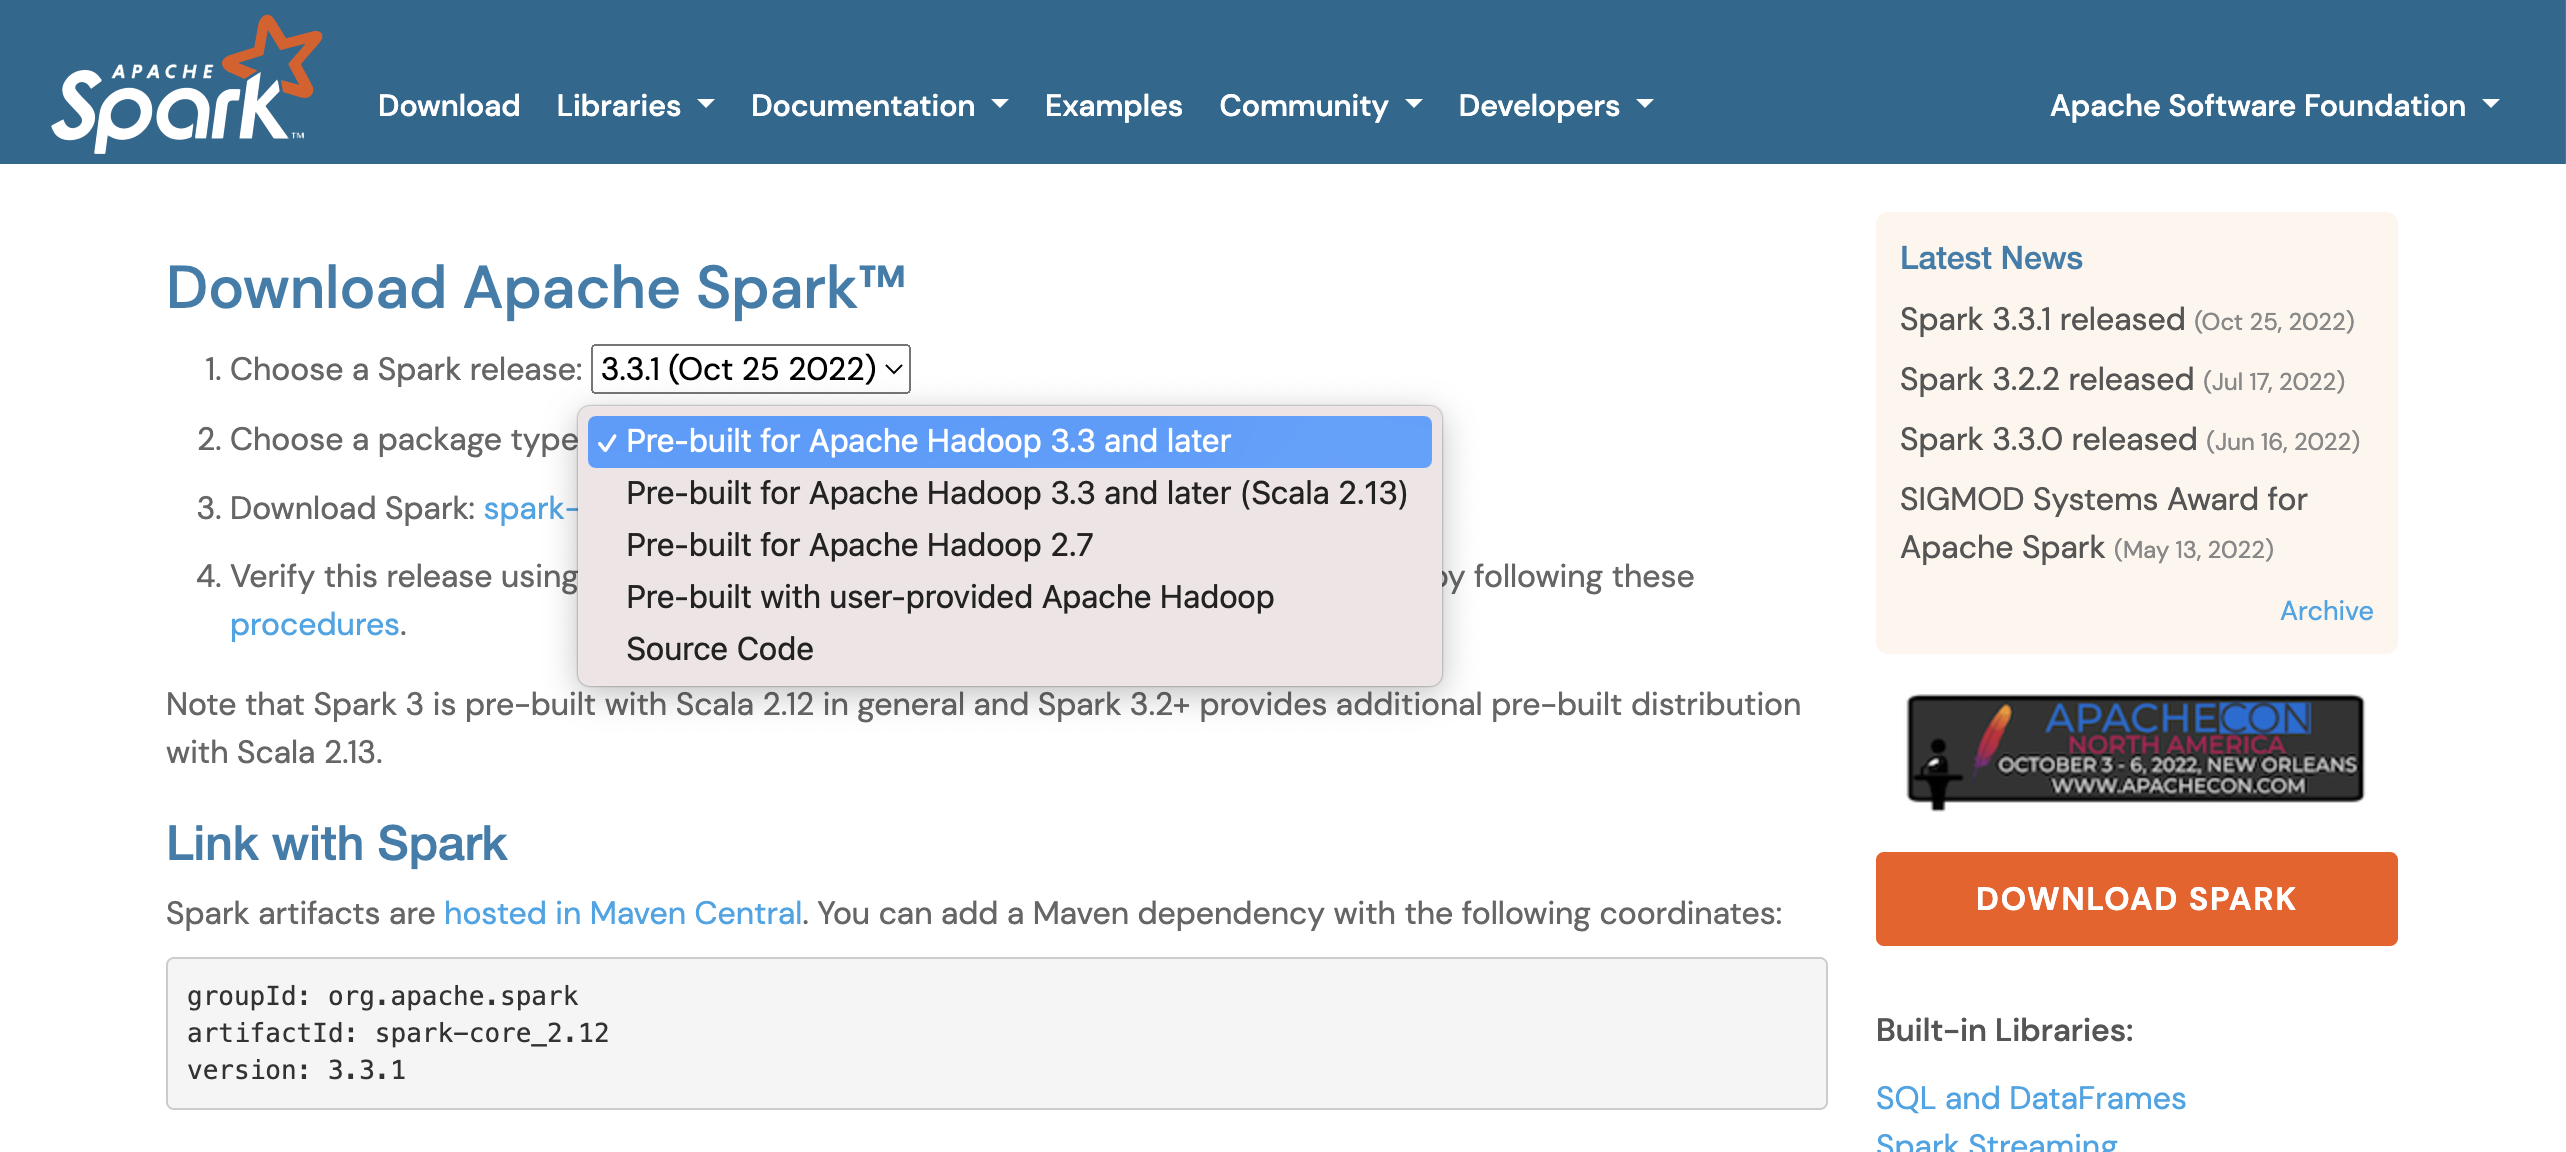

#### Download pre-built Spark with Hadoop

It might be necessary to change the variable `SPARK_VERSION` to stay on track with the latest Spark version.

In [2]:
SPARK_VERSION = '3.5.3'
SPARK_URL = f'https://dlcdn.apache.org/spark/spark-{SPARK_VERSION}/spark-{SPARK_VERSION}-bin-hadoop3.tgz'


In [3]:
import urllib.request

file_name = os.path.basename(SPARK_URL)
if os.path.isfile(file_name):
   print("{} already exists, not downloading".format(file_name))
else:
  print("Downloading {}".format(file_name))
  urllib.request.urlretrieve(SPARK_URL, file_name)

#### Unpack archive

In [4]:
import tarfile

dir_name = file_name[:-7]
if os.path.exists(dir_name):
  print("{} is already uncompressed".format(file_name))
else:
  print("Uncompressing {}".format(file_name))
  tar = tarfile.open(file_name)
  tar.extractall()
  tar.close()

Uncompressing spark-3.5.3-bin-hadoop3.tgz


#### Check Spark folder

You should now have a directory called `spark-3.5.3-bin-hadoop3`.





In [5]:
dir = os.path.splitext(os.path.basename(SPARK_URL))[0]
if dir in [d.name for d in os.scandir()]:
  print("Directory found: " + dir)

Directory found: spark-3.5.3-bin-hadoop3


## The components of a Spark application

The figure below (source: https://spark.apache.org/docs/latest/cluster-overview.html) depicts the components of a Spark application.



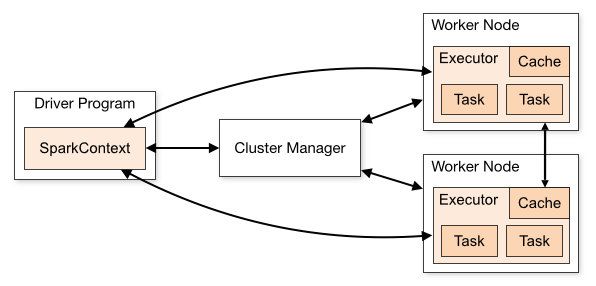

### Cluster manager

Spark requires a cluster of one or more computers to run independent sets of tasks. A _cluster manager_ is a software in charge of managing a cluster and allocating the resources needed to run applications.
The cluster manager used determines Spark's _deploy mode_.

There are currently four deploy modes supported by Spark:

 - Standalone
 - Apache Mesos (deprecated)
 - Hadoop YARN
 - Kubernetes

In standalone mode Spark uses a basic cluster manager that comes with the Spark distribution.

Note that “*Spark is agnostic to the underlying cluster manager. As long as it can acquire executor processes, and these communicate with each other, it is relatively easy to run it even on a cluster manager that also supports other applications (e.g. Mesos/YARN/Kubernetes).*” (https://spark.apache.org/docs/latest/cluster-overview.html#cluster-manager-types)








### The Spark driver

When a user submits an application to Spark, a _driver program_ is launched. The driver is a JVM process that runs the main function of the application and creates a `SparkContext`, the access point for the user to the Spark Cluster.

In addition to hosting the SparkContext, the driver is responsible for managing the whole application by distributing and scheduling tasks across executors, responding to worker nodes and to user's input, mantaining information about the Spark application.



#### Spark driver and deploy mode

The driver process can be deployed on one of the worker nodes or on a distinct machine. This can be configured by setting the `deploy-mode` option to `cluster` (driver runs on a node in the cluster) or `client` (driver runs locally—on the machine where the application is being submitted—as an external client). The default default deploy mode is `client`.



#### Which one to use: `client` or `cluster` `deploy-mode`?

In client deploy mode the driver runs locally while all tasks run on cluster worker nodes. This might affect your application's performance due to network latency because the driver needs to constantly exchange data with the worker nodes.

One solution to overcome network latency when using client mode is to deploy the driver on a machine that is physically co-located with the worker nodes. If that is not possible, then cluster deploy mode is preferable. Note however that the standalone mode does not currently support cluster mode for Python applications.

“_In client mode, the driver is launched directly within the spark-submit process which acts as a client to the cluster. The input and output of the application is attached to the console. Thus, this mode is especially suitable for applications that involve the REPL (e.g. Spark shell)_.” (https://spark.apache.org/docs/latest/submitting-applications.html)

In conclusion, client deploy mode is the better choice for interactive work or whenever the driver is physically co-located with or in the same local-area network as the cluster.



#### Application's Web UI

Each SparkContext launches a Web UI, by default on port 4040, that provides useful information about the application. This includes:
(see https://www.ibm.com/docs/en/izoda/1.1.0?topic=spark-web-interfaces https://spark.apache.org/docs/latest/monitoring.html#web-interfaces

A list of scheduler stages and tasks
A summary of RDD sizes and memory usage
Environmental information.
Information about the running executors

It hosts Web UI for the environment.
It splits a Spark application into tasks and schedules them to run on executors.
A driver is where the task scheduler lives and spawns tasks across workers.
A driver coordinates workers and overall execution of tasks.

### Spark executors

Executors are JVM processes on worker nodes in charge of running individual tasks of a given Spark job reporting results to the driver. They are launched at the beginning of a Spark application typically run for the entire lifetime of the application.

The Spark standalone follows a very basic resource allocation and job scheduling paradigm:
 - applications run in FIFO (first-in-first-out) order
 - each application will try and use all available nodes
 - by default, each executor uses up all cores available on the worker

(see https://spark.apache.org/docs/latest/job-scheduling.html#scheduling-across-applications and https://spark.apache.org/docs/latest/spark-standalone.html#executors-scheduling)

The default resource allotment in standalone mode can be improved by:
 -  limiting the number of nodes an application uses by setting the `spark.cores.max` configuration property
 - setting `spark.deploy.defaultCores`
 - controlling the amount of executor's memory by setting `spark.executor.memory`
 - setting `spark.executor.cores` to allow  multiple executors from the same application to be launched on the same worker

To improve resource sharing across applications you can Spark configure _dynamic resource allocation_ (default is static). This provides a mechanism to dynamically adjust the resources your application occupies based on the workload. Resources that are not needed are released and made available to other applications and can be reclaimed as needed according to well defined rules and prioritization.

Dynamic resource allocation is useful for serving multiple users on the cluster and in general for maximizing resource utilization.

#### Only one executor per worker node?

It should be clear by now that in general it is possible to have more than one executor on each worker node.

The image above depicting one executor per worker node reflects the default configuration for Spark standalone mode, where each executor allocates all cores available on the worker.

## Start a standalone master

Back to work after all the theory that can be overwhelming at first if you have never used Spark before.

We're going to define/modify some environment variables:

*   `SPARK_HOME` the path of the Spark installation
*   `PATH` is modified to include Spark's `bin` path

**Note:** `JAVA_HOME`, the path of the Java installation, has been defined earlier.

In [6]:
os.environ['SPARK_HOME'] = os.path.join('.', os.path.splitext(os.path.basename(SPARK_URL))[0])
os.environ['PATH'] = ':'.join([os.path.join(os.environ['SPARK_HOME'], 'bin'), os.environ['PATH']])

The Spark _master_ can be started with a simple shell script included in the Spark distribution:

```
$SPARK_HOME/sbin/start-master.sh
```

In [7]:
!$SPARK_HOME/sbin/start-master.sh

starting org.apache.spark.deploy.master.Master, logging to ./spark-3.5.3-bin-hadoop3/logs/spark-runner-org.apache.spark.deploy.master.Master-1-fv-az837-567.out


You should see in the output something like:

```
logging to /content/spark-3.5.0-bin-hadoop3/logs/spark--org.apache.spark.deploy.master.Master  ...
```

For convenience, we're going to funnel the output of the `start-master.sh` shell command to the Python variable `output` using the option `--out` of the `%%bash` magic.

But first, stop the running master with—you guessed it—`stop-master.sh`:

In [8]:
!$SPARK_HOME/sbin/stop-master.sh

stopping org.apache.spark.deploy.master.Master


In [9]:
%%bash --out output
$SPARK_HOME/sbin/start-master.sh

Extract the logfile name from `output` and print the content of the file:

In [10]:
logfile = output.split()[-1]
logfile_content = open(logfile, 'r').read()
print(logfile_content)

Spark Command: /usr/lib/jvm/temurin-11-jdk-amd64/bin/java -cp ./spark-3.5.3-bin-hadoop3/conf/:/home/runner/work/big_data/big_data/./spark-3.5.3-bin-hadoop3/jars/* -Xmx1g org.apache.spark.deploy.master.Master --host fv-az837-567.ymagj3ilz1se1nskuisabcixse.ex.internal.cloudapp.net --port 7077 --webui-port 8080
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
24/10/13 09:35:58 INFO Master: Started daemon with process name: 2160@fv-az837-567
24/10/13 09:35:58 INFO SignalUtils: Registering signal handler for TERM
24/10/13 09:35:58 INFO SignalUtils: Registering signal handler for HUP
24/10/13 09:35:58 INFO SignalUtils: Registering signal handler for INT
24/10/13 09:35:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/13 09:35:58 INFO SecurityManager: Changing view acls to: runner
24/10/13 09:35:58 INFO SecurityManager: Changing modify acls to: runner
24/10/13 09:35:58 INFO Secu

If the Spark master has been started successfully, the last line of the file should contain:
```
Master: I have been elected leader! New state: ALIVE
```

I don't know about you, but I enjoy looking at logfiles.

## Examine the master

So now we have a cluster manager but no workers. The current status of the Spark master (workers, running applications, etc.) can be viewed in the master's Web UI.



### Spark master's Web UI

The Spark master spawns a Web UI with default port $8080$ (see [services and ports](
https://spark.apache.org/docs/latest/security.html#configuring-ports-for-network-security)).

If you look closely at the `logfile`, you will see that the `MasterUI` server has actually been bound to port $8081$ because port $8080$ was not available.

Generate a Colab link for the Master Web UI and view it in a separate window.

**Note:** this works only when working on Google Colab. In other environments a different solution can be implemented to serve Web UIs.

In [11]:
# true if running on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import output

In [12]:
port = 8081

if IN_COLAB:
  output.serve_kernel_port_as_window(port)

In the new window you should see something like:

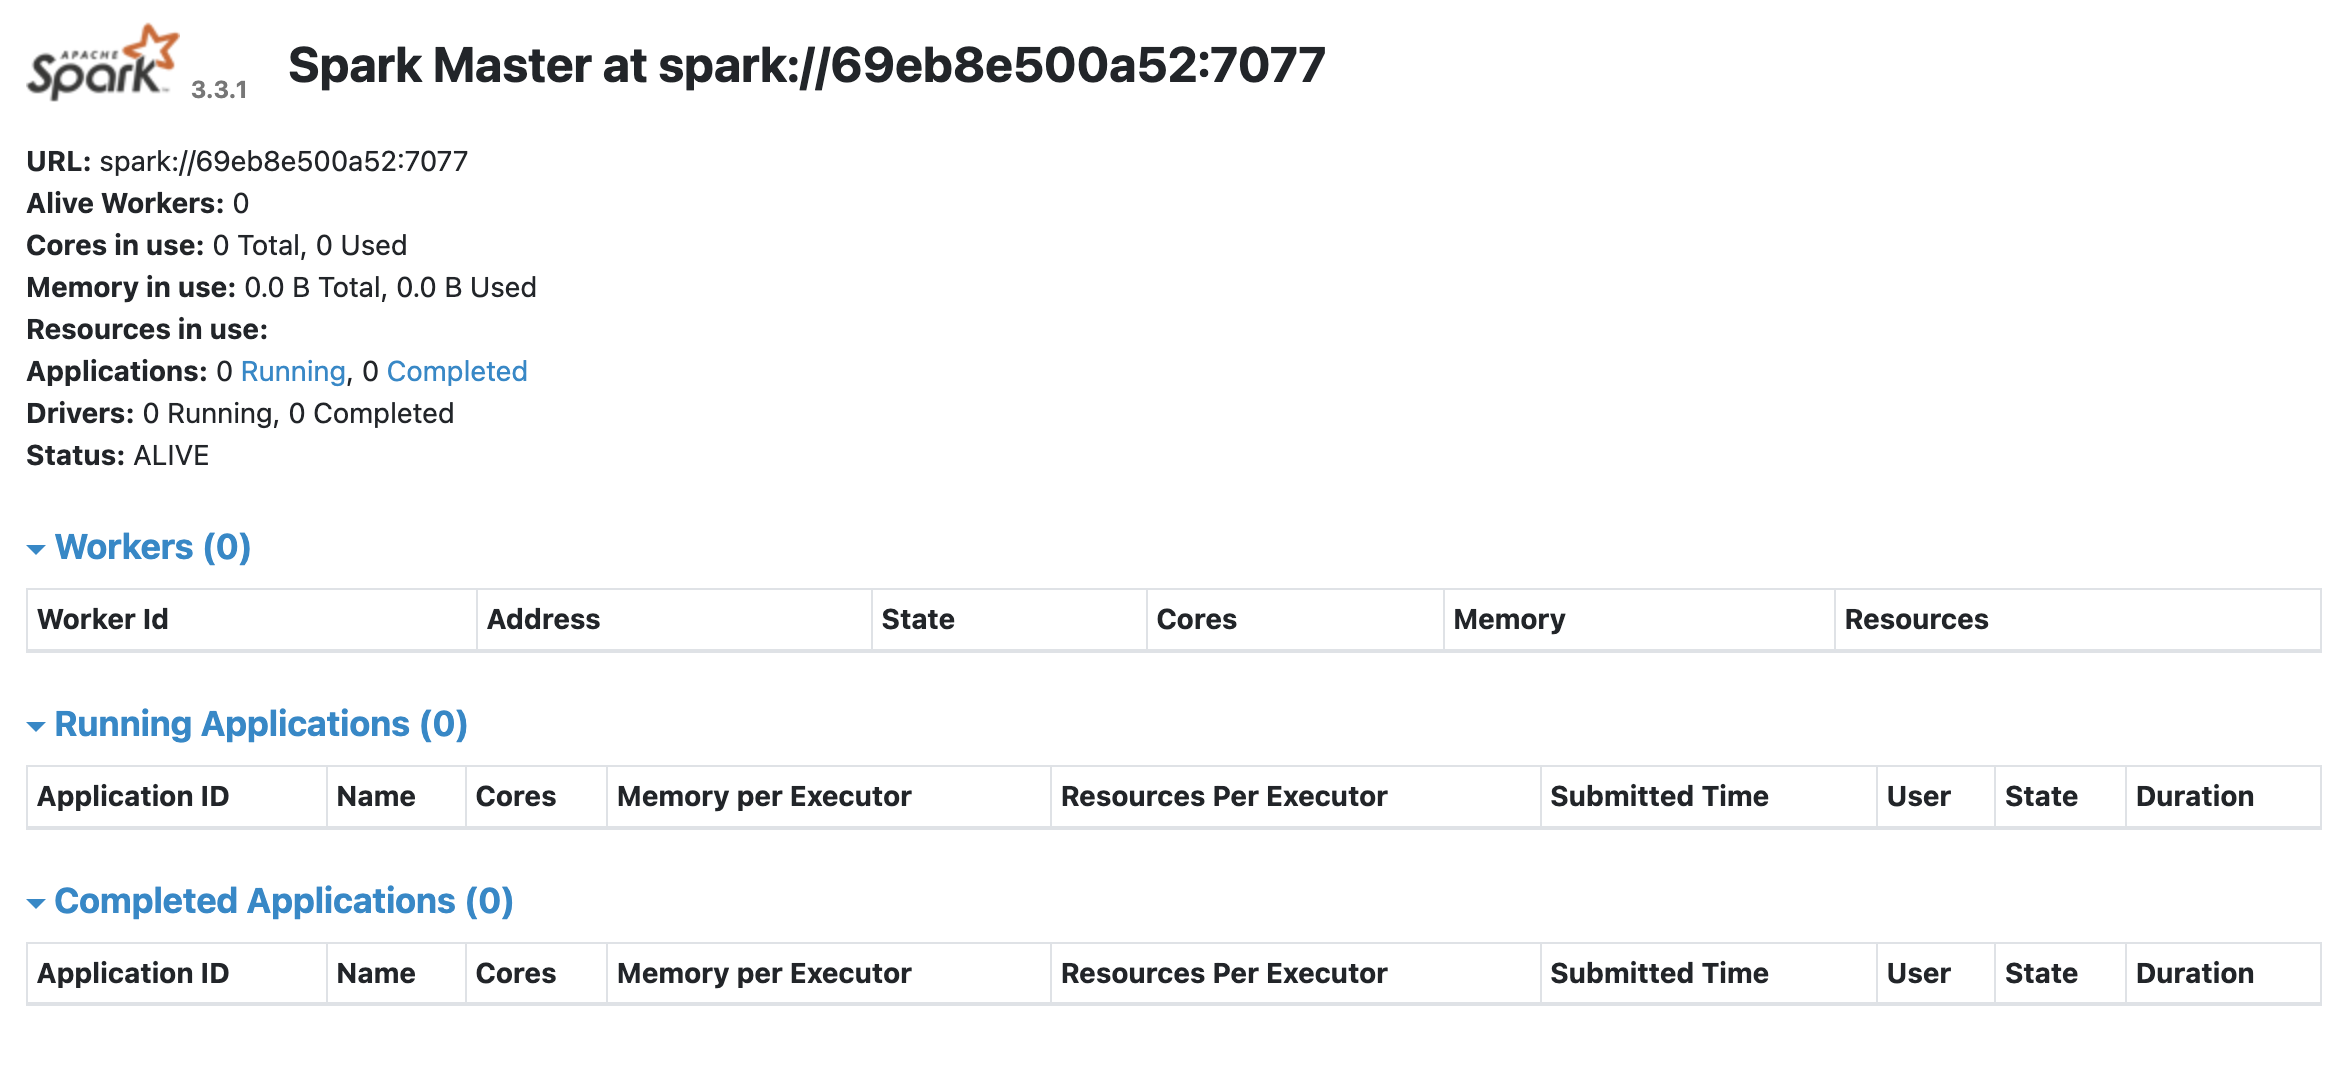

Notice the peculiar URL

```
spark://69eb8e500a52:7077
```

The random string in the URL is the hostname of the current Google Colab virtual machine.

You can view the current hostname with:

In [13]:
!echo $HOSTNAME

### How to set alternative ports for the Spark master

The ports used by `start-master.sh` can be configured in several ways:


*   by using the option  
  * `--port` for the service port
  *   `--webui-port` for the Web UI port

    Example:

    `$SPARK_HOME/sbin/start-master.sh  --webui-port 8087`

*   by setting the variables `SPARK_MASTER_PORT` / `SPARK_MASTER_WEBUI_PORT`

    before running the start script. For example:

    `export  SPARK_MASTER_WEBUI_PORT=8087`
    
*   by creating a file `spark-env.sh` in `$SPARK_HOME/conf/` containing the settings for the two variables `SPARK_MASTER_PORT` and `SPARK_MASTER_WEBUI_PORT` (`$SPARK_HOME/conf/` contains a template file that can be copied and adapted)

    before running the start script. For example:

    `export  SPARK_MASTER_WEBUI_PORT=8087`



#### Pick a random free port

Since the Spark master is created on the fly here on Google Colab, for the Web UI we are going to use a random free port selected with `portpicker`. The Spsrk service port 7077 doesn't seem to be reserved, so we are going to keep the default value of $7077$.

In general, if you are running the Spark master on a dedicated machine, you might want to configure the ports in `spark-env.sh`.

In [14]:
import portpicker
port = portpicker.pick_unused_port()
os.environ['SPARK_MASTER_WEBUI_PORT'] = str(port)
print("Port picked is: {}".format(port))

Port picked is: 34725


In [15]:
%%bash --out bash_output
$SPARK_HOME/sbin/stop-master.sh
$SPARK_HOME/sbin/start-master.sh --webui-port $SPARK_MASTER_WEBUI_PORT

In [16]:
logfile = bash_output.split()[-1]
logfile_content = open(logfile, 'r').read()
print(logfile_content)

Spark Command: /usr/lib/jvm/temurin-11-jdk-amd64/bin/java -cp ./spark-3.5.3-bin-hadoop3/conf/:/home/runner/work/big_data/big_data/./spark-3.5.3-bin-hadoop3/jars/* -Xmx1g org.apache.spark.deploy.master.Master --host fv-az837-567.ymagj3ilz1se1nskuisabcixse.ex.internal.cloudapp.net --port 7077 --webui-port 34725 --webui-port 34725
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
24/10/13 09:36:00 INFO Master: Started daemon with process name: 2254@fv-az837-567
24/10/13 09:36:00 INFO SignalUtils: Registering signal handler for TERM
24/10/13 09:36:00 INFO SignalUtils: Registering signal handler for HUP
24/10/13 09:36:00 INFO SignalUtils: Registering signal handler for INT
24/10/13 09:36:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/13 09:36:01 INFO SecurityManager: Changing view acls to: runner
24/10/13 09:36:01 INFO SecurityManager: Changing modify acls to: runner
24/10/1

Now the Spark master's Web UI can be reached at the new `port`.

In [17]:
if IN_COLAB:
  webUI = output.serve_kernel_port_as_window(port)

### Port $7077$

Port $7077$ is the default port for submitting Spark applications.

When a user submits an application to the Spark master at port $7077$, this starts a driver program that runs the application on the Spark cluster.

Next we are going to submit a Spark application but before that it is necessary to create one or more workers.

## Start one worker

In order to start a worker you need the URL for the running master node, that is something like `spark://${HOSTNAME}:7077`.

This is a simple command:

```
$SPARK_HOME/sbin/start-worker.sh spark://${HOSTNAME}:7077
```

In [18]:
!$SPARK_HOME/sbin/start-worker.sh spark://$(hostname):7077


starting org.apache.spark.deploy.worker.Worker, logging to ./spark-3.5.3-bin-hadoop3/logs/spark-runner-org.apache.spark.deploy.worker.Worker-1-fv-az837-567.out


In the master's Web UI you should now see the newly created worker.

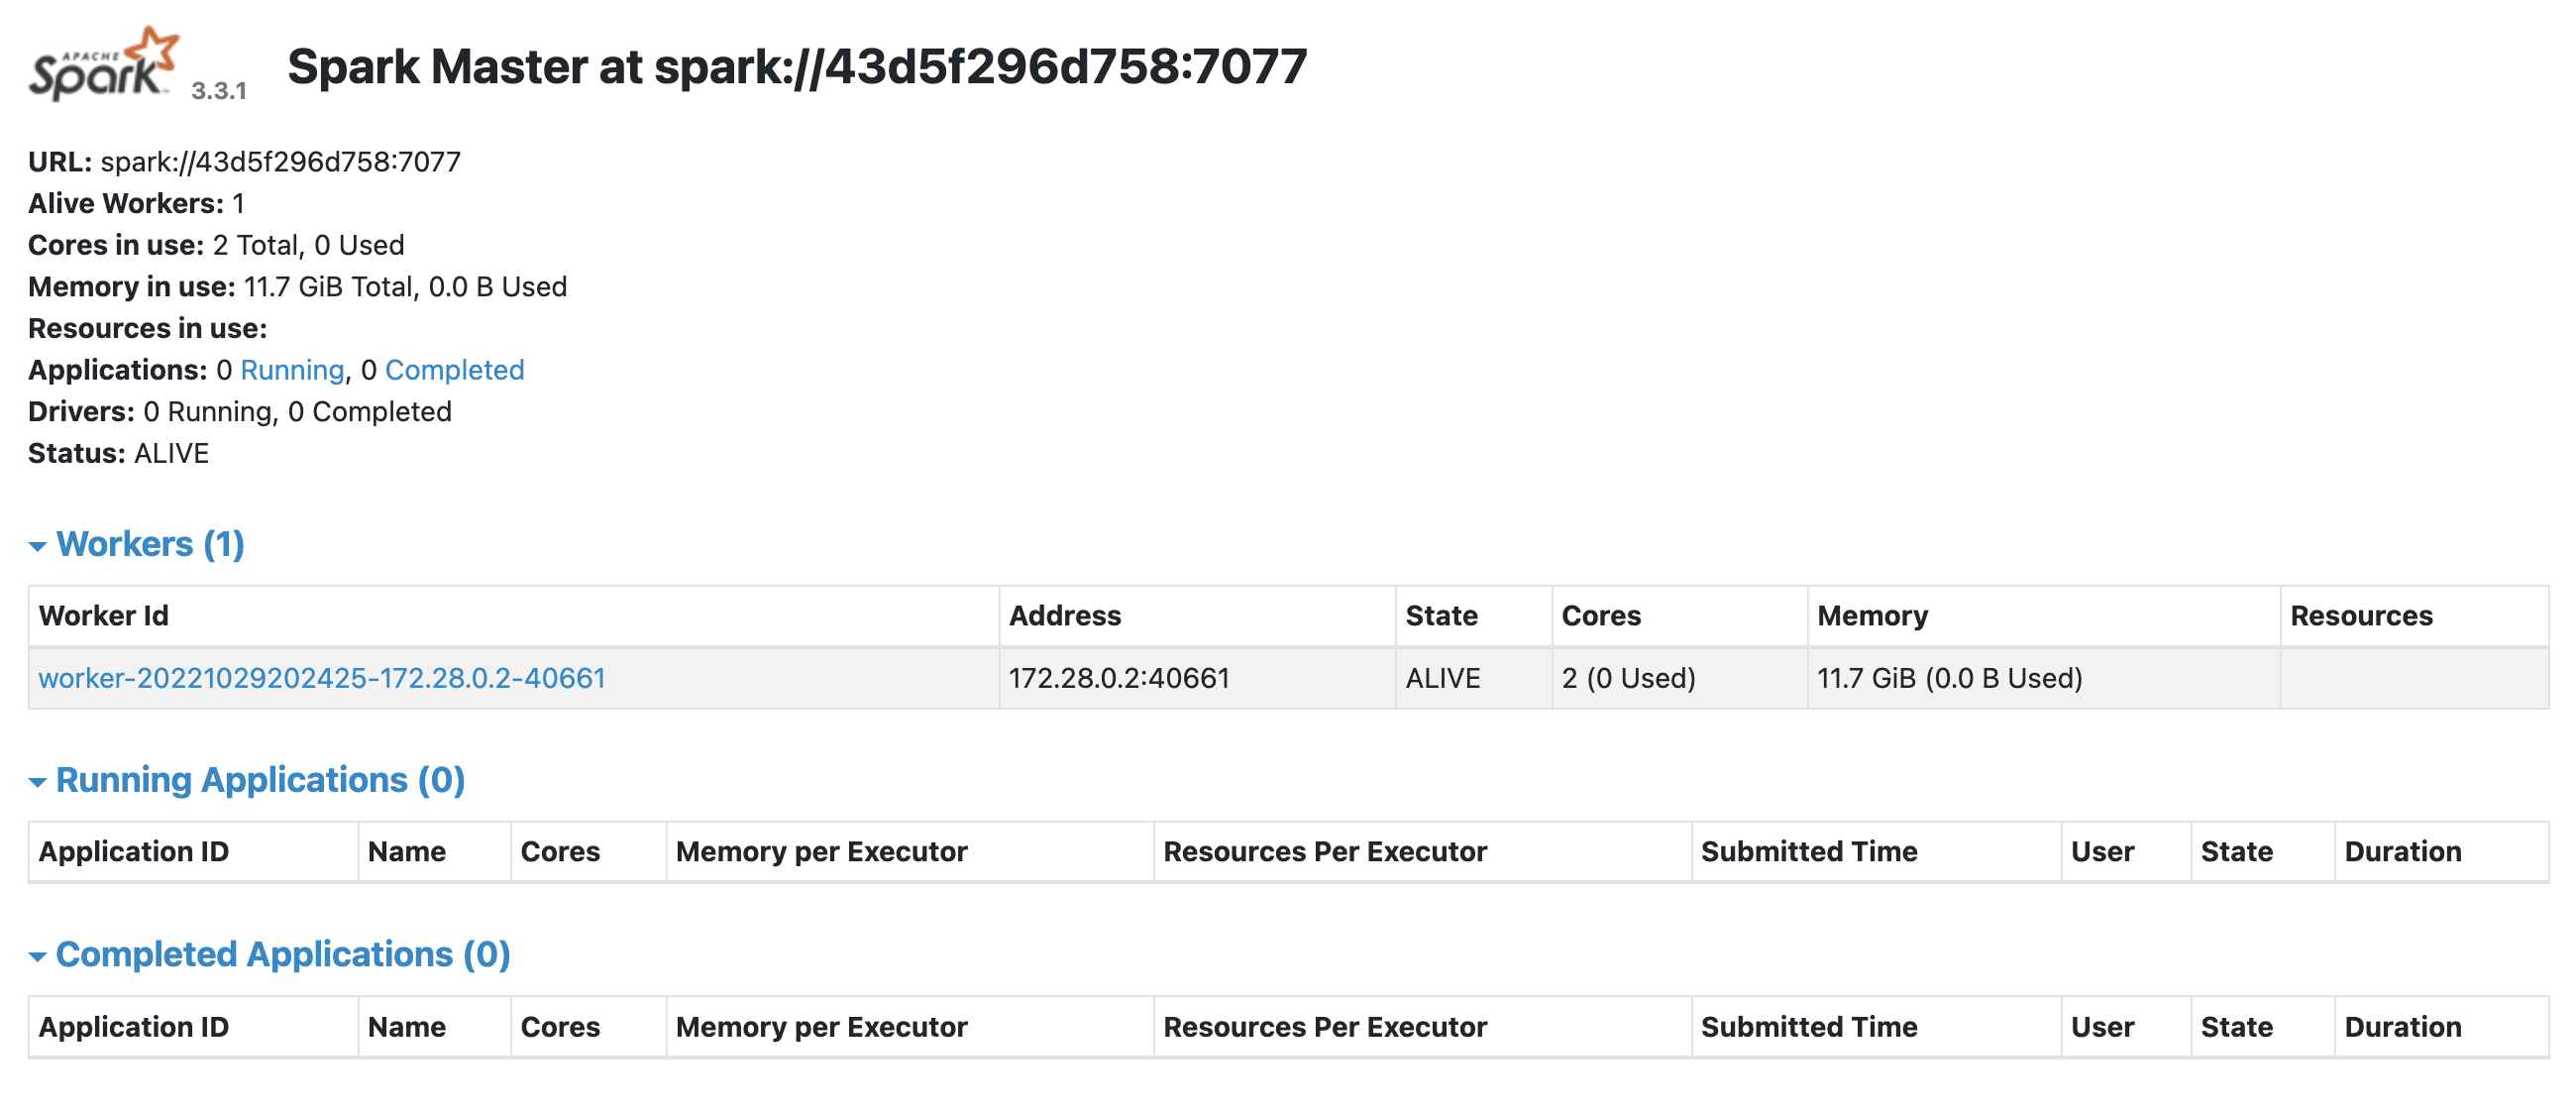

## Submit a Spark application with `spark-submit`

This step might take some time.

We are going to run the SparkPi demo from the examples in the Spark distribution contained in `spark-examples*.jar`.

We are submitting the job with [`spark-submit`](https://spark.apache.org/docs/latest/submitting-applications.html). The output of this job is an approximation of π computed with a Montecarlo method (see also https://spark.apache.org/examples.html).

While the application is running you can check its progress on the Spark master Web UI.

In [19]:
%%bash

export EXAMPLES_JAR=$(find $SPARK_HOME/examples/jars/ -name "spark-examples_2*")

$SPARK_HOME/bin/spark-submit \
  --class org.apache.spark.examples.SparkPi \
  --master spark://${HOSTNAME}:7077 \
  $EXAMPLES_JAR \
  100

24/10/13 09:36:06 INFO SparkContext: Running Spark version 3.5.3


24/10/13 09:36:06 INFO SparkContext: OS info Linux, 6.5.0-1025-azure, amd64


24/10/13 09:36:06 INFO SparkContext: Java version 11.0.24


24/10/13 09:36:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


24/10/13 09:36:06 INFO ResourceUtils: ==============================================================


24/10/13 09:36:06 INFO ResourceUtils: No custom resources configured for spark.driver.


24/10/13 09:36:06 INFO ResourceUtils: ==============================================================


24/10/13 09:36:06 INFO SparkContext: Submitted application: Spark Pi


24/10/13 09:36:06 INFO ResourceProfile: Default ResourceProfile created, executor resources: Map(memory -> name: memory, amount: 1024, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)


24/10/13 09:36:06 INFO ResourceProfile: Limiting resource is cpu


24/10/13 09:36:06 INFO ResourceProfileManager: Added ResourceProfile id: 0


24/10/13 09:36:06 INFO SecurityManager: Changing view acls to: runner


24/10/13 09:36:06 INFO SecurityManager: Changing modify acls to: runner


24/10/13 09:36:06 INFO SecurityManager: Changing view acls groups to: 


24/10/13 09:36:06 INFO SecurityManager: Changing modify acls groups to: 


24/10/13 09:36:06 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users with view permissions: runner; groups with view permissions: EMPTY; users with modify permissions: runner; groups with modify permissions: EMPTY


24/10/13 09:36:06 INFO Utils: Successfully started service 'sparkDriver' on port 35049.


24/10/13 09:36:06 INFO SparkEnv: Registering MapOutputTracker


24/10/13 09:36:06 INFO SparkEnv: Registering BlockManagerMaster


24/10/13 09:36:06 INFO BlockManagerMasterEndpoint: Using org.apache.spark.storage.DefaultTopologyMapper for getting topology information


24/10/13 09:36:06 INFO BlockManagerMasterEndpoint: BlockManagerMasterEndpoint up


24/10/13 09:36:06 INFO SparkEnv: Registering BlockManagerMasterHeartbeat


24/10/13 09:36:06 INFO DiskBlockManager: Created local directory at /tmp/blockmgr-6aff4905-1572-4187-b6db-de72c5fd96d2


24/10/13 09:36:06 INFO MemoryStore: MemoryStore started with capacity 434.4 MiB


24/10/13 09:36:06 INFO SparkEnv: Registering OutputCommitCoordinator


24/10/13 09:36:07 INFO JettyUtils: Start Jetty 0.0.0.0:4040 for SparkUI


24/10/13 09:36:07 INFO Utils: Successfully started service 'SparkUI' on port 4040.


24/10/13 09:36:07 INFO SparkContext: Added JAR file:/home/runner/work/big_data/big_data/spark-3.5.3-bin-hadoop3/examples/jars/spark-examples_2.12-3.5.3.jar at spark://fv-az837-567.ymagj3ilz1se1nskuisabcixse.ex.internal.cloudapp.net:35049/jars/spark-examples_2.12-3.5.3.jar with timestamp 1728812166441


24/10/13 09:36:07 INFO StandaloneAppClient$ClientEndpoint: Connecting to master spark://fv-az837-567:7077...


24/10/13 09:36:07 INFO TransportClientFactory: Successfully created connection to fv-az837-567/10.1.1.7:7077 after 22 ms (0 ms spent in bootstraps)


24/10/13 09:36:07 INFO StandaloneSchedulerBackend: Connected to Spark cluster with app ID app-20241013093607-0000


24/10/13 09:36:07 INFO StandaloneAppClient$ClientEndpoint: Executor added: app-20241013093607-0000/0 on worker-20241013093604-10.1.1.7-42205 (10.1.1.7:42205) with 4 core(s)


24/10/13 09:36:07 INFO StandaloneSchedulerBackend: Granted executor ID app-20241013093607-0000/0 on hostPort 10.1.1.7:42205 with 4 core(s), 1024.0 MiB RAM


24/10/13 09:36:07 INFO Utils: Successfully started service 'org.apache.spark.network.netty.NettyBlockTransferService' on port 38051.


24/10/13 09:36:07 INFO NettyBlockTransferService: Server created on fv-az837-567.ymagj3ilz1se1nskuisabcixse.ex.internal.cloudapp.net:38051


24/10/13 09:36:07 INFO BlockManager: Using org.apache.spark.storage.RandomBlockReplicationPolicy for block replication policy


24/10/13 09:36:07 INFO BlockManagerMaster: Registering BlockManager BlockManagerId(driver, fv-az837-567.ymagj3ilz1se1nskuisabcixse.ex.internal.cloudapp.net, 38051, None)


24/10/13 09:36:07 INFO BlockManagerMasterEndpoint: Registering block manager fv-az837-567.ymagj3ilz1se1nskuisabcixse.ex.internal.cloudapp.net:38051 with 434.4 MiB RAM, BlockManagerId(driver, fv-az837-567.ymagj3ilz1se1nskuisabcixse.ex.internal.cloudapp.net, 38051, None)


24/10/13 09:36:07 INFO BlockManagerMaster: Registered BlockManager BlockManagerId(driver, fv-az837-567.ymagj3ilz1se1nskuisabcixse.ex.internal.cloudapp.net, 38051, None)


24/10/13 09:36:07 INFO BlockManager: Initialized BlockManager: BlockManagerId(driver, fv-az837-567.ymagj3ilz1se1nskuisabcixse.ex.internal.cloudapp.net, 38051, None)


24/10/13 09:36:07 INFO StandaloneAppClient$ClientEndpoint: Executor updated: app-20241013093607-0000/0 is now RUNNING


24/10/13 09:36:07 INFO StandaloneSchedulerBackend: SchedulerBackend is ready for scheduling beginning after reached minRegisteredResourcesRatio: 0.0


24/10/13 09:36:08 INFO SparkContext: Starting job: reduce at SparkPi.scala:38


24/10/13 09:36:08 INFO DAGScheduler: Got job 0 (reduce at SparkPi.scala:38) with 100 output partitions


24/10/13 09:36:08 INFO DAGScheduler: Final stage: ResultStage 0 (reduce at SparkPi.scala:38)


24/10/13 09:36:08 INFO DAGScheduler: Parents of final stage: List()


24/10/13 09:36:08 INFO DAGScheduler: Missing parents: List()


24/10/13 09:36:08 INFO DAGScheduler: Submitting ResultStage 0 (MapPartitionsRDD[1] at map at SparkPi.scala:34), which has no missing parents


24/10/13 09:36:08 INFO MemoryStore: Block broadcast_0 stored as values in memory (estimated size 4.0 KiB, free 434.4 MiB)


24/10/13 09:36:08 INFO MemoryStore: Block broadcast_0_piece0 stored as bytes in memory (estimated size 2.3 KiB, free 434.4 MiB)


24/10/13 09:36:08 INFO BlockManagerInfo: Added broadcast_0_piece0 in memory on fv-az837-567.ymagj3ilz1se1nskuisabcixse.ex.internal.cloudapp.net:38051 (size: 2.3 KiB, free: 434.4 MiB)


24/10/13 09:36:08 INFO SparkContext: Created broadcast 0 from broadcast at DAGScheduler.scala:1585


24/10/13 09:36:08 INFO DAGScheduler: Submitting 100 missing tasks from ResultStage 0 (MapPartitionsRDD[1] at map at SparkPi.scala:34) (first 15 tasks are for partitions Vector(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14))


24/10/13 09:36:08 INFO TaskSchedulerImpl: Adding task set 0.0 with 100 tasks resource profile 0


24/10/13 09:36:10 INFO StandaloneSchedulerBackend$StandaloneDriverEndpoint: Registered executor NettyRpcEndpointRef(spark-client://Executor) (10.1.1.7:60644) with ID 0,  ResourceProfileId 0


24/10/13 09:36:10 INFO BlockManagerMasterEndpoint: Registering block manager 10.1.1.7:33041 with 434.4 MiB RAM, BlockManagerId(0, 10.1.1.7, 33041, None)


24/10/13 09:36:10 INFO TaskSetManager: Starting task 0.0 in stage 0.0 (TID 0) (10.1.1.7, executor 0, partition 0, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Starting task 1.0 in stage 0.0 (TID 1) (10.1.1.7, executor 0, partition 1, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Starting task 2.0 in stage 0.0 (TID 2) (10.1.1.7, executor 0, partition 2, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Starting task 3.0 in stage 0.0 (TID 3) (10.1.1.7, executor 0, partition 3, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO BlockManagerInfo: Added broadcast_0_piece0 in memory on 10.1.1.7:33041 (size: 2.3 KiB, free: 434.4 MiB)


24/10/13 09:36:10 INFO TaskSetManager: Starting task 4.0 in stage 0.0 (TID 4) (10.1.1.7, executor 0, partition 4, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Starting task 5.0 in stage 0.0 (TID 5) (10.1.1.7, executor 0, partition 5, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Starting task 6.0 in stage 0.0 (TID 6) (10.1.1.7, executor 0, partition 6, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Starting task 7.0 in stage 0.0 (TID 7) (10.1.1.7, executor 0, partition 7, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Starting task 8.0 in stage 0.0 (TID 8) (10.1.1.7, executor 0, partition 8, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Starting task 9.0 in stage 0.0 (TID 9) (10.1.1.7, executor 0, partition 9, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Finished task 3.0 in stage 0.0 (TID 3) in 521 ms on 10.1.1.7 (executor 0) (1/100)


24/10/13 09:36:10 INFO TaskSetManager: Finished task 5.0 in stage 0.0 (TID 5) in 39 ms on 10.1.1.7 (executor 0) (2/100)


24/10/13 09:36:10 INFO TaskSetManager: Finished task 6.0 in stage 0.0 (TID 6) in 30 ms on 10.1.1.7 (executor 0) (3/100)


24/10/13 09:36:10 INFO TaskSetManager: Finished task 2.0 in stage 0.0 (TID 2) in 534 ms on 10.1.1.7 (executor 0) (4/100)


24/10/13 09:36:10 INFO TaskSetManager: Finished task 1.0 in stage 0.0 (TID 1) in 539 ms on 10.1.1.7 (executor 0) (5/100)


24/10/13 09:36:10 INFO TaskSetManager: Finished task 0.0 in stage 0.0 (TID 0) in 570 ms on 10.1.1.7 (executor 0) (6/100)


24/10/13 09:36:10 INFO TaskSetManager: Starting task 10.0 in stage 0.0 (TID 10) (10.1.1.7, executor 0, partition 10, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Starting task 11.0 in stage 0.0 (TID 11) (10.1.1.7, executor 0, partition 11, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Finished task 4.0 in stage 0.0 (TID 4) in 81 ms on 10.1.1.7 (executor 0) (7/100)


24/10/13 09:36:10 INFO TaskSetManager: Finished task 8.0 in stage 0.0 (TID 8) in 49 ms on 10.1.1.7 (executor 0) (8/100)


24/10/13 09:36:10 INFO TaskSetManager: Starting task 12.0 in stage 0.0 (TID 12) (10.1.1.7, executor 0, partition 12, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Finished task 7.0 in stage 0.0 (TID 7) in 61 ms on 10.1.1.7 (executor 0) (9/100)


24/10/13 09:36:10 INFO TaskSetManager: Starting task 13.0 in stage 0.0 (TID 13) (10.1.1.7, executor 0, partition 13, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Finished task 9.0 in stage 0.0 (TID 9) in 61 ms on 10.1.1.7 (executor 0) (10/100)


24/10/13 09:36:10 INFO TaskSetManager: Starting task 14.0 in stage 0.0 (TID 14) (10.1.1.7, executor 0, partition 14, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Starting task 15.0 in stage 0.0 (TID 15) (10.1.1.7, executor 0, partition 15, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Finished task 10.0 in stage 0.0 (TID 10) in 57 ms on 10.1.1.7 (executor 0) (11/100)


24/10/13 09:36:10 INFO TaskSetManager: Finished task 13.0 in stage 0.0 (TID 13) in 41 ms on 10.1.1.7 (executor 0) (12/100)


24/10/13 09:36:10 INFO TaskSetManager: Finished task 12.0 in stage 0.0 (TID 12) in 56 ms on 10.1.1.7 (executor 0) (13/100)


24/10/13 09:36:10 INFO TaskSetManager: Starting task 16.0 in stage 0.0 (TID 16) (10.1.1.7, executor 0, partition 16, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Starting task 17.0 in stage 0.0 (TID 17) (10.1.1.7, executor 0, partition 17, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Finished task 11.0 in stage 0.0 (TID 11) in 77 ms on 10.1.1.7 (executor 0) (14/100)


24/10/13 09:36:10 INFO TaskSetManager: Finished task 15.0 in stage 0.0 (TID 15) in 27 ms on 10.1.1.7 (executor 0) (15/100)


24/10/13 09:36:10 INFO TaskSetManager: Starting task 18.0 in stage 0.0 (TID 18) (10.1.1.7, executor 0, partition 18, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Starting task 19.0 in stage 0.0 (TID 19) (10.1.1.7, executor 0, partition 19, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Finished task 16.0 in stage 0.0 (TID 16) in 21 ms on 10.1.1.7 (executor 0) (16/100)


24/10/13 09:36:10 INFO TaskSetManager: Starting task 20.0 in stage 0.0 (TID 20) (10.1.1.7, executor 0, partition 20, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Finished task 19.0 in stage 0.0 (TID 19) in 34 ms on 10.1.1.7 (executor 0) (17/100)


24/10/13 09:36:10 INFO TaskSetManager: Starting task 21.0 in stage 0.0 (TID 21) (10.1.1.7, executor 0, partition 21, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Finished task 14.0 in stage 0.0 (TID 14) in 90 ms on 10.1.1.7 (executor 0) (18/100)


24/10/13 09:36:10 INFO TaskSetManager: Starting task 22.0 in stage 0.0 (TID 22) (10.1.1.7, executor 0, partition 22, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:10 INFO TaskSetManager: Finished task 18.0 in stage 0.0 (TID 18) in 62 ms on 10.1.1.7 (executor 0) (19/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 23.0 in stage 0.0 (TID 23) (10.1.1.7, executor 0, partition 23, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 17.0 in stage 0.0 (TID 17) in 109 ms on 10.1.1.7 (executor 0) (20/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 24.0 in stage 0.0 (TID 24) (10.1.1.7, executor 0, partition 24, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 20.0 in stage 0.0 (TID 20) in 74 ms on 10.1.1.7 (executor 0) (21/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 21.0 in stage 0.0 (TID 21) in 57 ms on 10.1.1.7 (executor 0) (22/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 25.0 in stage 0.0 (TID 25) (10.1.1.7, executor 0, partition 25, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 22.0 in stage 0.0 (TID 22) in 61 ms on 10.1.1.7 (executor 0) (23/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 26.0 in stage 0.0 (TID 26) (10.1.1.7, executor 0, partition 26, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 23.0 in stage 0.0 (TID 23) in 44 ms on 10.1.1.7 (executor 0) (24/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 27.0 in stage 0.0 (TID 27) (10.1.1.7, executor 0, partition 27, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 28.0 in stage 0.0 (TID 28) (10.1.1.7, executor 0, partition 28, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 25.0 in stage 0.0 (TID 25) in 33 ms on 10.1.1.7 (executor 0) (25/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 24.0 in stage 0.0 (TID 24) in 39 ms on 10.1.1.7 (executor 0) (26/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 29.0 in stage 0.0 (TID 29) (10.1.1.7, executor 0, partition 29, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 30.0 in stage 0.0 (TID 30) (10.1.1.7, executor 0, partition 30, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 26.0 in stage 0.0 (TID 26) in 37 ms on 10.1.1.7 (executor 0) (27/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 31.0 in stage 0.0 (TID 31) (10.1.1.7, executor 0, partition 31, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 28.0 in stage 0.0 (TID 28) in 45 ms on 10.1.1.7 (executor 0) (28/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 32.0 in stage 0.0 (TID 32) (10.1.1.7, executor 0, partition 32, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 29.0 in stage 0.0 (TID 29) in 48 ms on 10.1.1.7 (executor 0) (29/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 33.0 in stage 0.0 (TID 33) (10.1.1.7, executor 0, partition 33, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 30.0 in stage 0.0 (TID 30) in 52 ms on 10.1.1.7 (executor 0) (30/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 34.0 in stage 0.0 (TID 34) (10.1.1.7, executor 0, partition 34, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 27.0 in stage 0.0 (TID 27) in 68 ms on 10.1.1.7 (executor 0) (31/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 35.0 in stage 0.0 (TID 35) (10.1.1.7, executor 0, partition 35, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 32.0 in stage 0.0 (TID 32) in 32 ms on 10.1.1.7 (executor 0) (32/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 36.0 in stage 0.0 (TID 36) (10.1.1.7, executor 0, partition 36, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 31.0 in stage 0.0 (TID 31) in 56 ms on 10.1.1.7 (executor 0) (33/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 37.0 in stage 0.0 (TID 37) (10.1.1.7, executor 0, partition 37, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 38.0 in stage 0.0 (TID 38) (10.1.1.7, executor 0, partition 38, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 34.0 in stage 0.0 (TID 34) in 44 ms on 10.1.1.7 (executor 0) (34/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 33.0 in stage 0.0 (TID 33) in 47 ms on 10.1.1.7 (executor 0) (35/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 39.0 in stage 0.0 (TID 39) (10.1.1.7, executor 0, partition 39, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 37.0 in stage 0.0 (TID 37) in 23 ms on 10.1.1.7 (executor 0) (36/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 40.0 in stage 0.0 (TID 40) (10.1.1.7, executor 0, partition 40, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 35.0 in stage 0.0 (TID 35) in 57 ms on 10.1.1.7 (executor 0) (37/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 41.0 in stage 0.0 (TID 41) (10.1.1.7, executor 0, partition 41, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 38.0 in stage 0.0 (TID 38) in 52 ms on 10.1.1.7 (executor 0) (38/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 42.0 in stage 0.0 (TID 42) (10.1.1.7, executor 0, partition 42, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 43.0 in stage 0.0 (TID 43) (10.1.1.7, executor 0, partition 43, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 44.0 in stage 0.0 (TID 44) (10.1.1.7, executor 0, partition 44, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 40.0 in stage 0.0 (TID 40) in 38 ms on 10.1.1.7 (executor 0) (39/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 39.0 in stage 0.0 (TID 39) in 49 ms on 10.1.1.7 (executor 0) (40/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 36.0 in stage 0.0 (TID 36) in 84 ms on 10.1.1.7 (executor 0) (41/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 45.0 in stage 0.0 (TID 45) (10.1.1.7, executor 0, partition 45, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 41.0 in stage 0.0 (TID 41) in 32 ms on 10.1.1.7 (executor 0) (42/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 46.0 in stage 0.0 (TID 46) (10.1.1.7, executor 0, partition 46, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 45.0 in stage 0.0 (TID 45) in 25 ms on 10.1.1.7 (executor 0) (43/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 47.0 in stage 0.0 (TID 47) (10.1.1.7, executor 0, partition 47, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 44.0 in stage 0.0 (TID 44) in 62 ms on 10.1.1.7 (executor 0) (44/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 48.0 in stage 0.0 (TID 48) (10.1.1.7, executor 0, partition 48, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 43.0 in stage 0.0 (TID 43) in 76 ms on 10.1.1.7 (executor 0) (45/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 49.0 in stage 0.0 (TID 49) (10.1.1.7, executor 0, partition 49, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 42.0 in stage 0.0 (TID 42) in 80 ms on 10.1.1.7 (executor 0) (46/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 46.0 in stage 0.0 (TID 46) in 45 ms on 10.1.1.7 (executor 0) (47/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 50.0 in stage 0.0 (TID 50) (10.1.1.7, executor 0, partition 50, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 51.0 in stage 0.0 (TID 51) (10.1.1.7, executor 0, partition 51, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 47.0 in stage 0.0 (TID 47) in 54 ms on 10.1.1.7 (executor 0) (48/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 52.0 in stage 0.0 (TID 52) (10.1.1.7, executor 0, partition 52, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 49.0 in stage 0.0 (TID 49) in 31 ms on 10.1.1.7 (executor 0) (49/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 53.0 in stage 0.0 (TID 53) (10.1.1.7, executor 0, partition 53, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 54.0 in stage 0.0 (TID 54) (10.1.1.7, executor 0, partition 54, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 55.0 in stage 0.0 (TID 55) (10.1.1.7, executor 0, partition 55, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 51.0 in stage 0.0 (TID 51) in 30 ms on 10.1.1.7 (executor 0) (50/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 48.0 in stage 0.0 (TID 48) in 61 ms on 10.1.1.7 (executor 0) (51/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 50.0 in stage 0.0 (TID 50) in 32 ms on 10.1.1.7 (executor 0) (52/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 56.0 in stage 0.0 (TID 56) (10.1.1.7, executor 0, partition 56, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 57.0 in stage 0.0 (TID 57) (10.1.1.7, executor 0, partition 57, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 52.0 in stage 0.0 (TID 52) in 64 ms on 10.1.1.7 (executor 0) (53/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 53.0 in stage 0.0 (TID 53) in 43 ms on 10.1.1.7 (executor 0) (54/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 58.0 in stage 0.0 (TID 58) (10.1.1.7, executor 0, partition 58, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 55.0 in stage 0.0 (TID 55) in 45 ms on 10.1.1.7 (executor 0) (55/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 59.0 in stage 0.0 (TID 59) (10.1.1.7, executor 0, partition 59, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 54.0 in stage 0.0 (TID 54) in 67 ms on 10.1.1.7 (executor 0) (56/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 60.0 in stage 0.0 (TID 60) (10.1.1.7, executor 0, partition 60, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 59.0 in stage 0.0 (TID 59) in 24 ms on 10.1.1.7 (executor 0) (57/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 61.0 in stage 0.0 (TID 61) (10.1.1.7, executor 0, partition 61, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 56.0 in stage 0.0 (TID 56) in 45 ms on 10.1.1.7 (executor 0) (58/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 62.0 in stage 0.0 (TID 62) (10.1.1.7, executor 0, partition 62, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 57.0 in stage 0.0 (TID 57) in 61 ms on 10.1.1.7 (executor 0) (59/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 63.0 in stage 0.0 (TID 63) (10.1.1.7, executor 0, partition 63, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 58.0 in stage 0.0 (TID 58) in 65 ms on 10.1.1.7 (executor 0) (60/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 64.0 in stage 0.0 (TID 64) (10.1.1.7, executor 0, partition 64, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 61.0 in stage 0.0 (TID 61) in 33 ms on 10.1.1.7 (executor 0) (61/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 65.0 in stage 0.0 (TID 65) (10.1.1.7, executor 0, partition 65, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 60.0 in stage 0.0 (TID 60) in 54 ms on 10.1.1.7 (executor 0) (62/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 66.0 in stage 0.0 (TID 66) (10.1.1.7, executor 0, partition 66, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 64.0 in stage 0.0 (TID 64) in 27 ms on 10.1.1.7 (executor 0) (63/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 67.0 in stage 0.0 (TID 67) (10.1.1.7, executor 0, partition 67, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 68.0 in stage 0.0 (TID 68) (10.1.1.7, executor 0, partition 68, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 63.0 in stage 0.0 (TID 63) in 55 ms on 10.1.1.7 (executor 0) (64/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 62.0 in stage 0.0 (TID 62) in 66 ms on 10.1.1.7 (executor 0) (65/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 69.0 in stage 0.0 (TID 69) (10.1.1.7, executor 0, partition 69, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 65.0 in stage 0.0 (TID 65) in 47 ms on 10.1.1.7 (executor 0) (66/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 70.0 in stage 0.0 (TID 70) (10.1.1.7, executor 0, partition 70, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 66.0 in stage 0.0 (TID 66) in 45 ms on 10.1.1.7 (executor 0) (67/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 71.0 in stage 0.0 (TID 71) (10.1.1.7, executor 0, partition 71, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 72.0 in stage 0.0 (TID 72) (10.1.1.7, executor 0, partition 72, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 73.0 in stage 0.0 (TID 73) (10.1.1.7, executor 0, partition 73, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 74.0 in stage 0.0 (TID 74) (10.1.1.7, executor 0, partition 74, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 68.0 in stage 0.0 (TID 68) in 71 ms on 10.1.1.7 (executor 0) (68/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 70.0 in stage 0.0 (TID 70) in 50 ms on 10.1.1.7 (executor 0) (69/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 67.0 in stage 0.0 (TID 67) in 74 ms on 10.1.1.7 (executor 0) (70/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 69.0 in stage 0.0 (TID 69) in 60 ms on 10.1.1.7 (executor 0) (71/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 75.0 in stage 0.0 (TID 75) (10.1.1.7, executor 0, partition 75, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 72.0 in stage 0.0 (TID 72) in 44 ms on 10.1.1.7 (executor 0) (72/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 76.0 in stage 0.0 (TID 76) (10.1.1.7, executor 0, partition 76, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 73.0 in stage 0.0 (TID 73) in 48 ms on 10.1.1.7 (executor 0) (73/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 77.0 in stage 0.0 (TID 77) (10.1.1.7, executor 0, partition 77, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 74.0 in stage 0.0 (TID 74) in 47 ms on 10.1.1.7 (executor 0) (74/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 78.0 in stage 0.0 (TID 78) (10.1.1.7, executor 0, partition 78, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 71.0 in stage 0.0 (TID 71) in 63 ms on 10.1.1.7 (executor 0) (75/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 79.0 in stage 0.0 (TID 79) (10.1.1.7, executor 0, partition 79, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 80.0 in stage 0.0 (TID 80) (10.1.1.7, executor 0, partition 80, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 81.0 in stage 0.0 (TID 81) (10.1.1.7, executor 0, partition 81, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 77.0 in stage 0.0 (TID 77) in 47 ms on 10.1.1.7 (executor 0) (76/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 78.0 in stage 0.0 (TID 78) in 36 ms on 10.1.1.7 (executor 0) (77/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 76.0 in stage 0.0 (TID 76) in 50 ms on 10.1.1.7 (executor 0) (78/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 82.0 in stage 0.0 (TID 82) (10.1.1.7, executor 0, partition 82, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 75.0 in stage 0.0 (TID 75) in 70 ms on 10.1.1.7 (executor 0) (79/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 83.0 in stage 0.0 (TID 83) (10.1.1.7, executor 0, partition 83, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 79.0 in stage 0.0 (TID 79) in 21 ms on 10.1.1.7 (executor 0) (80/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 84.0 in stage 0.0 (TID 84) (10.1.1.7, executor 0, partition 84, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 80.0 in stage 0.0 (TID 80) in 44 ms on 10.1.1.7 (executor 0) (81/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 85.0 in stage 0.0 (TID 85) (10.1.1.7, executor 0, partition 85, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 82.0 in stage 0.0 (TID 82) in 28 ms on 10.1.1.7 (executor 0) (82/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 86.0 in stage 0.0 (TID 86) (10.1.1.7, executor 0, partition 86, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 83.0 in stage 0.0 (TID 83) in 30 ms on 10.1.1.7 (executor 0) (83/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 87.0 in stage 0.0 (TID 87) (10.1.1.7, executor 0, partition 87, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 84.0 in stage 0.0 (TID 84) in 20 ms on 10.1.1.7 (executor 0) (84/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 88.0 in stage 0.0 (TID 88) (10.1.1.7, executor 0, partition 88, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 81.0 in stage 0.0 (TID 81) in 65 ms on 10.1.1.7 (executor 0) (85/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 89.0 in stage 0.0 (TID 89) (10.1.1.7, executor 0, partition 89, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 88.0 in stage 0.0 (TID 88) in 12 ms on 10.1.1.7 (executor 0) (86/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 90.0 in stage 0.0 (TID 90) (10.1.1.7, executor 0, partition 90, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Starting task 91.0 in stage 0.0 (TID 91) (10.1.1.7, executor 0, partition 91, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 87.0 in stage 0.0 (TID 87) in 48 ms on 10.1.1.7 (executor 0) (87/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 89.0 in stage 0.0 (TID 89) in 34 ms on 10.1.1.7 (executor 0) (88/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 92.0 in stage 0.0 (TID 92) (10.1.1.7, executor 0, partition 92, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 86.0 in stage 0.0 (TID 86) in 84 ms on 10.1.1.7 (executor 0) (89/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 93.0 in stage 0.0 (TID 93) (10.1.1.7, executor 0, partition 93, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 90.0 in stage 0.0 (TID 90) in 33 ms on 10.1.1.7 (executor 0) (90/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 94.0 in stage 0.0 (TID 94) (10.1.1.7, executor 0, partition 94, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 91.0 in stage 0.0 (TID 91) in 44 ms on 10.1.1.7 (executor 0) (91/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 95.0 in stage 0.0 (TID 95) (10.1.1.7, executor 0, partition 95, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 92.0 in stage 0.0 (TID 92) in 26 ms on 10.1.1.7 (executor 0) (92/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 96.0 in stage 0.0 (TID 96) (10.1.1.7, executor 0, partition 96, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 85.0 in stage 0.0 (TID 85) in 119 ms on 10.1.1.7 (executor 0) (93/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 97.0 in stage 0.0 (TID 97) (10.1.1.7, executor 0, partition 97, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 95.0 in stage 0.0 (TID 95) in 22 ms on 10.1.1.7 (executor 0) (94/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 98.0 in stage 0.0 (TID 98) (10.1.1.7, executor 0, partition 98, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 96.0 in stage 0.0 (TID 96) in 17 ms on 10.1.1.7 (executor 0) (95/100)


24/10/13 09:36:11 INFO TaskSetManager: Starting task 99.0 in stage 0.0 (TID 99) (10.1.1.7, executor 0, partition 99, PROCESS_LOCAL, 9368 bytes) 


24/10/13 09:36:11 INFO TaskSetManager: Finished task 97.0 in stage 0.0 (TID 97) in 24 ms on 10.1.1.7 (executor 0) (96/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 94.0 in stage 0.0 (TID 94) in 51 ms on 10.1.1.7 (executor 0) (97/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 93.0 in stage 0.0 (TID 93) in 62 ms on 10.1.1.7 (executor 0) (98/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 98.0 in stage 0.0 (TID 98) in 29 ms on 10.1.1.7 (executor 0) (99/100)


24/10/13 09:36:11 INFO TaskSetManager: Finished task 99.0 in stage 0.0 (TID 99) in 37 ms on 10.1.1.7 (executor 0) (100/100)


24/10/13 09:36:11 INFO TaskSchedulerImpl: Removed TaskSet 0.0, whose tasks have all completed, from pool 


24/10/13 09:36:11 INFO DAGScheduler: ResultStage 0 (reduce at SparkPi.scala:38) finished in 3.585 s


24/10/13 09:36:11 INFO DAGScheduler: Job 0 is finished. Cancelling potential speculative or zombie tasks for this job


24/10/13 09:36:11 INFO TaskSchedulerImpl: Killing all running tasks in stage 0: Stage finished


24/10/13 09:36:11 INFO DAGScheduler: Job 0 finished: reduce at SparkPi.scala:38, took 3.680019 s


Pi is roughly 3.1423875142387514


24/10/13 09:36:11 INFO SparkContext: SparkContext is stopping with exitCode 0.


24/10/13 09:36:11 INFO SparkUI: Stopped Spark web UI at http://fv-az837-567.ymagj3ilz1se1nskuisabcixse.ex.internal.cloudapp.net:4040


24/10/13 09:36:11 INFO StandaloneSchedulerBackend: Shutting down all executors


24/10/13 09:36:11 INFO StandaloneSchedulerBackend$StandaloneDriverEndpoint: Asking each executor to shut down


24/10/13 09:36:11 INFO MapOutputTrackerMasterEndpoint: MapOutputTrackerMasterEndpoint stopped!


24/10/13 09:36:12 INFO MemoryStore: MemoryStore cleared


24/10/13 09:36:12 INFO BlockManager: BlockManager stopped


24/10/13 09:36:12 INFO BlockManagerMaster: BlockManagerMaster stopped


24/10/13 09:36:12 INFO OutputCommitCoordinator$OutputCommitCoordinatorEndpoint: OutputCommitCoordinator stopped!


24/10/13 09:36:12 INFO SparkContext: Successfully stopped SparkContext


24/10/13 09:36:12 INFO ShutdownHookManager: Shutdown hook called


24/10/13 09:36:12 INFO ShutdownHookManager: Deleting directory /tmp/spark-119dd964-db66-4a99-9a7f-11689d187e34


24/10/13 09:36:12 INFO ShutdownHookManager: Deleting directory /tmp/spark-5191283c-bbae-48f9-b92e-1b4424bddf5f


What is the estimated value of $\pi$? (look for the line "Pi is roughly..." in the previous output).

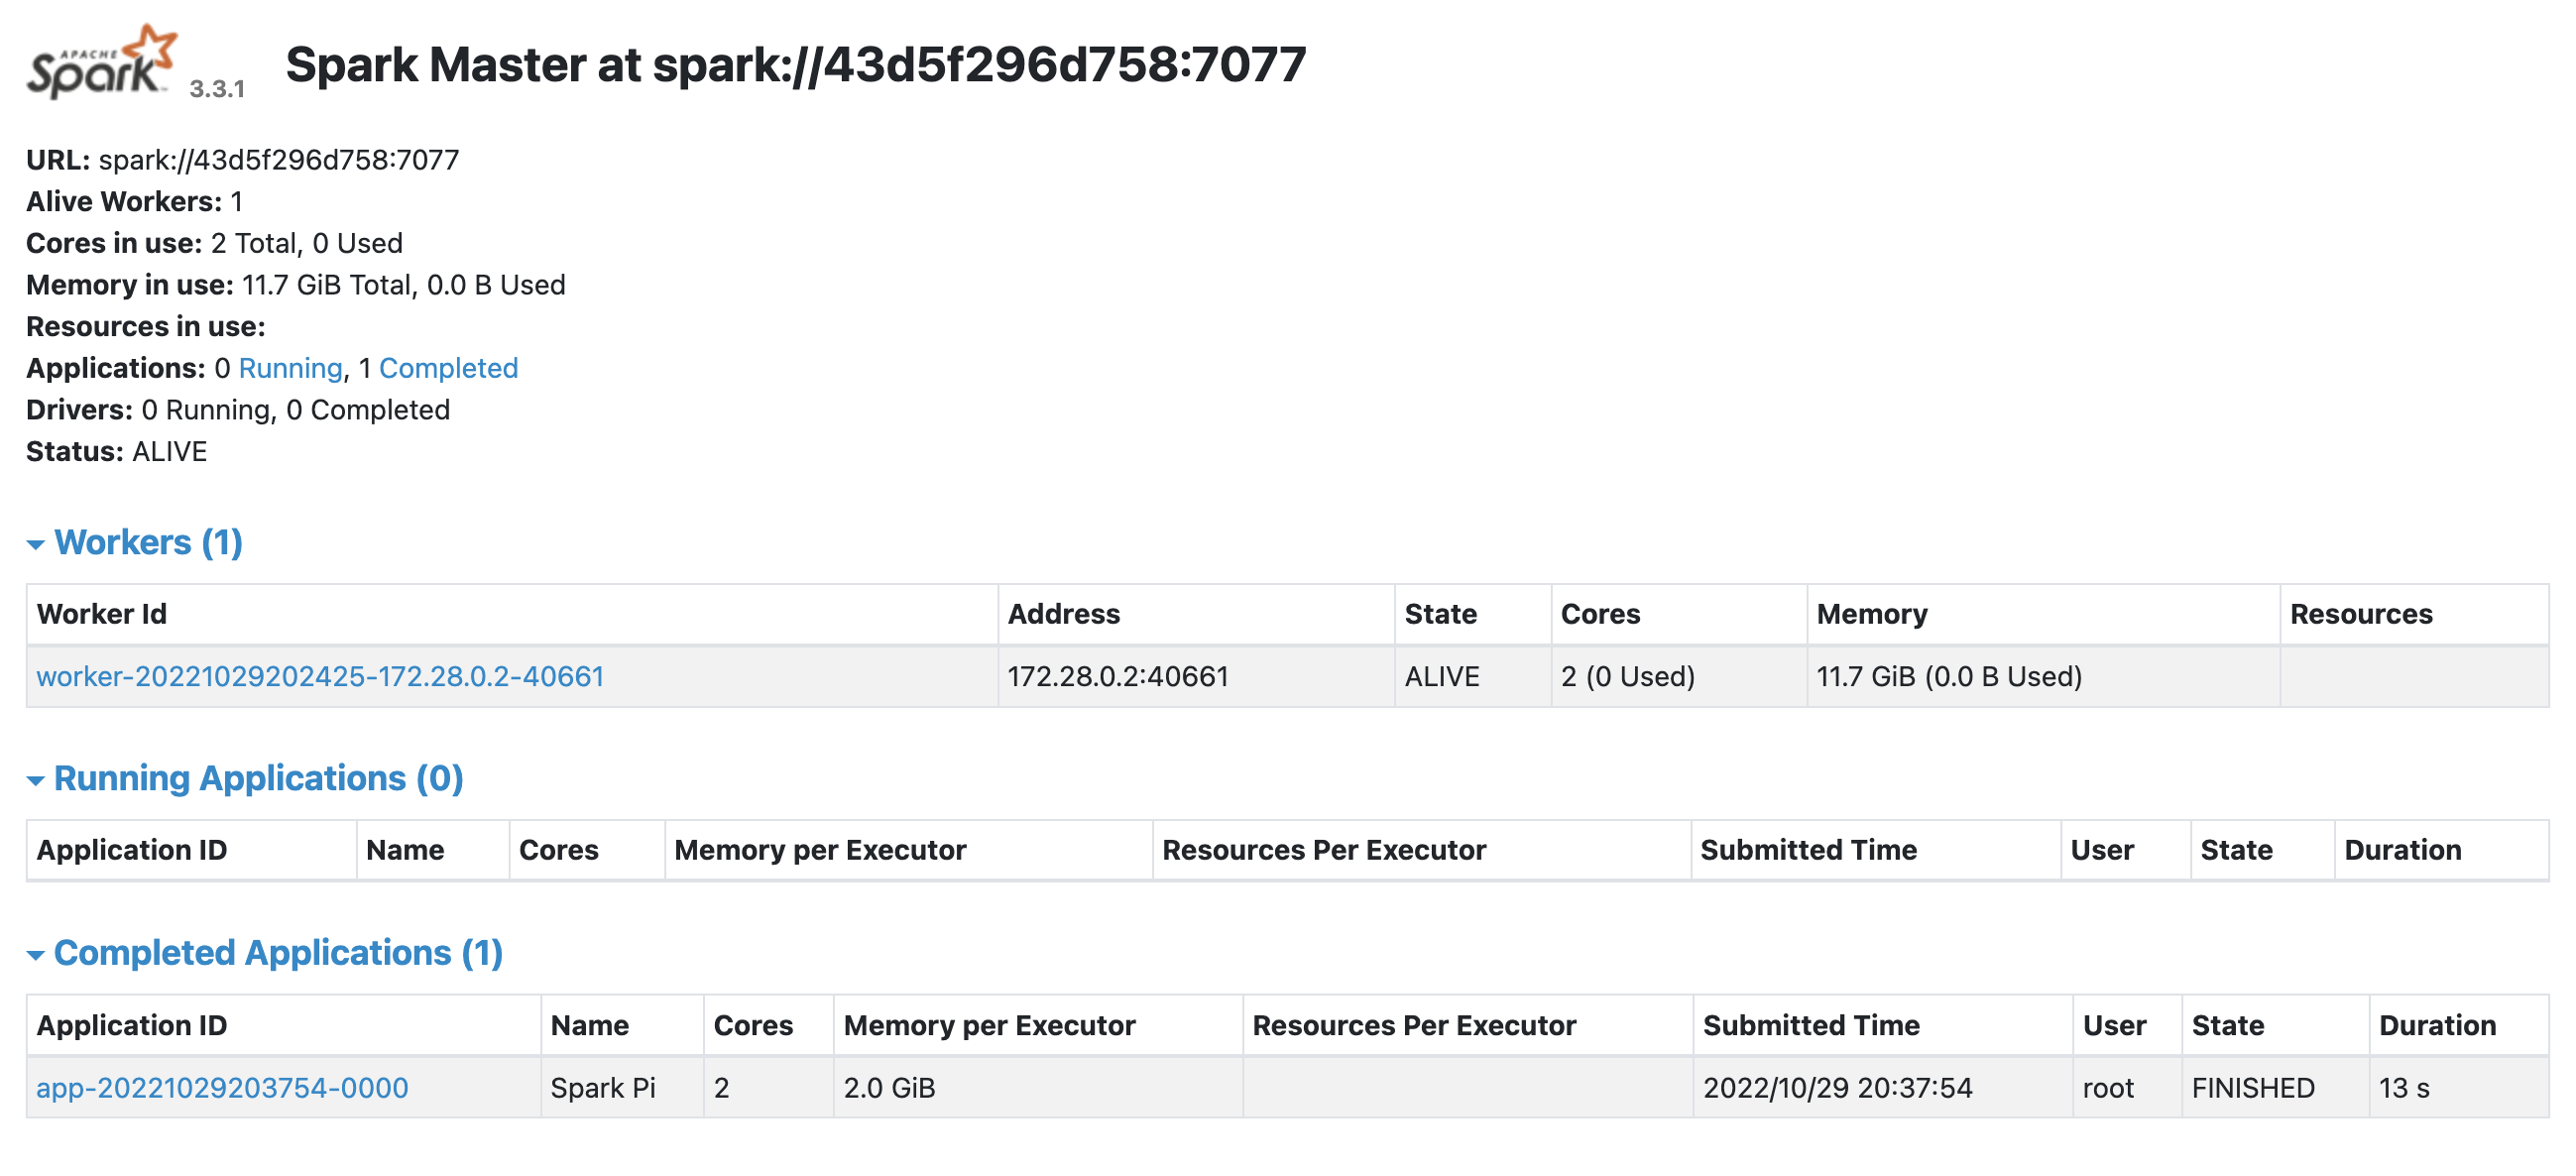

## Stop all services

In [20]:
!$SPARK_HOME/sbin/stop-worker.sh
!$SPARK_HOME/sbin/stop-master.sh

stopping org.apache.spark.deploy.worker.Worker


stopping org.apache.spark.deploy.master.Master
